# Fine-Tuning Bert on IMDB Movie Review Dataset

## Introduction

BERT is a powerful language model developed by Google. Its ability to understand the context of words in a sentence makes it particularly well-suited for sentiment analysis tasks.

The IMDB dataset is a collection of 50,000 movie reviews, each labeled as positive or negative. In this notebook, we will fine-tune a pre-trained BERT model to achieve high accuracy on sentiment classification of movie reviews.

**Note:** This notebook requires a GPU to run efficiently due to the computational demands of fine-tuning BERT.

## Installing necessary packages

In [ ]:
!pip install transformers
!pip install torch
!pip install pandas
!pip install scikit-learn;
!pip install datasets
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Importing Libraries

Here we import the necessary libraries for our task. These libraries provide tools for data handling, working with the BERT model, and evaluating our results.

In [ ]:
import os
import re
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from transformers import TrainingArguments, Trainer

## Hugging Face Token Setup

This cell handles authentication with Hugging Face. It retrieves your Hugging Face token, which you need to obtain and store securely beforehand. This token allows us to download the pre-trained BERT model.

**Follow these steps to get your Hugging Face token and add it to Colab:**

1. **Get your Hugging Face Token:**
   * Go to the Hugging Face website (https://huggingface.co/) and log in to your account.
   * Click on your profile picture in the top right corner.
   * Select "Settings".
   * In the left sidebar, click on "Access Tokens".
   * Click on "New token".
   * Give your token a name (e.g., "Colab Token").
   * Under "Role", select "Read".
   * Click "Create".
   * **Important:** Copy the token value that's generated. This is your `HF_TOKEN`. Store it securely.

2. **Store your Token in Colab Secrets:**
   * In this Colab notebook, click on the "Secrets" tab in the left sidebar (it looks like a key).
   * Click on "Add a new secret".
   * In the "Name" field, enter `HF_TOKEN`.
   * In the "Value" field, paste your Hugging Face token that you copied earlier.
   * Click "Add".

Now you can run the code below to log in to Hugging Face.

In [ ]:
import os
from google.colab import userdata
hf_token=userdata.get('HF_TOKEN')

# Now, you can use the token to authenticate with Hugging Face
!huggingface-cli login --token "$hf_token"

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `READ_AGAIN` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `READ_AGAIN`


## Download the IMDB Dataset

This cell downloads the IMDB dataset directly from Kaggle.

**Before running this code, follow these steps to set up the Kaggle API:**

1. **Create a Kaggle Account:** If you don't have one already, create an account on Kaggle (https://www.kaggle.com/).
2. **Get your Kaggle API Token:** Go to your Kaggle account settings, and under the 'API' section, click 'Create New API Token'. This will download a `kaggle.json` file.
3. **Upload `kaggle.json` to Colab:** In the Files tab of this Colab notebook, click 'Upload' and select the downloaded `kaggle.json` file.

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
! unzip imdb-dataset-of-50k-movie-reviews.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 89% 23.0M/25.7M [00:02<00:00, 22.8MB/s]
100% 25.7M/25.7M [00:02<00:00, 12.5MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


## Manual Dataset Upload (Optional)

If you prefer to upload the dataset manually (e.g., if you have the dataset file on your local machine), you can use this method. However, keep in mind that uploading large files to Colab can be slow.

To use this, uncomment the code. Then, run the cell. This will prompt you to select the dataset file from your computer.

In [ ]:
# from google.colab import files

# # This will prompt you to upload files
# uploaded = files.upload()

In [ ]:
import os
os.rename('/content/IMDB Dataset.csv', '/content/imdb_dataset.csv')

## Key Customizable Variables
This section defines key variables that control the behavior of the model and training process. You can adjust these values to experiment with different settings and potentially improve performance.

The default values are chosen to work well in the Colab environment on free tier, which has limited memory. If you are running this notebook on a machine with more resources, you can increase some of these values (e.g., `my_max_length`, `sample_size`, `batch_size`).

In [ ]:
# This section contains key variables that can be adjusted based on the environment or use case.
# For Colab, we set conservative defaults to avoid memory issues.

# Maximum token length for tokenizer (adjust based on text length and memory limits)
my_max_length = 256  # This can be adjusted as needed for different datasets

# Sample size for dataset reduction (set to a small number to avoid memory issues in Colab)
sample_size = None  # Total samples: 25 positive, 25 negative

# Number of training epochs (can reduce or increase based on dataset size and overfitting concerns)
num_train_epochs = 3  # Adjust this for faster or slower training

# Learning rate for the optimizer
learning_rate = 3e-5  # Smaller values often result in more stable learning

# Early stopping patience to avoid overfitting
early_stopping_patience = 2  # Stop training if no improvement after this many evaluations

#Batch size of data for training
train_batch_size = 16  # Adjust based on available memory

# Batch size of data for evaluation
eval_batch_size = 16  # Adjust based on available memory

# Warmup steps for learning rate scheduler
warmup_steps = 500  # Increase if the learning rate schedule needs a slower start

# Logging steps (how often to log during training)
logging_steps = 10  # Adjust to log more or less frequently during training

# Evaluation steps (how often to evaluate the model during training)
eval_steps = 500  # Evaluate the model every 500 steps

# Save steps (how often to save model checkpoints)
save_steps = 500  # Save model every 500 steps

# Weight decay for regularization (use a small value to prevent overfitting)
weight_decay = 0.1  # Adjust for stronger or weaker regularization

# Test size for splitting dataset
test_size = 0.2  # 20% of the dataset will be used for testing

## Loading the IMDB Movie Review Dataset

In [ ]:
# import pandas as pd
df = pd.read_csv('/content/imdb_dataset.csv')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Balance the Dataset (Optional)

This function creates a balanced subset of the data, ensuring an equal number of positive and negative reviews. This can be helpful for preventing the model from being biased towards one sentiment class.

If you set the `sample_size` variable in the 'Configuration' section, this function will be used to create a smaller, balanced dataset. If `sample_size` is set to `None`, the full dataset will be used.

**Explanation of the `create_subset` function:**

1. Converts the 'sentiment' column to binary labels (1 for positive, 0 for negative).
2. If `sample_size` is provided, it samples an equal number of positive and negative reviews.
3. Concatenates the samples and shuffles the data.
4. If no `sample_size` is provided, it uses the full dataset.

In [ ]:
def create_subset(dataframe, sample_size=None, random_seed=42):
    # Convert sentiment into binary labels (1 for positive, 0 for negative)
    dataframe['label'] = dataframe['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

    if sample_size:
        # Separate positive and negative reviews
        positive_reviews = dataframe[dataframe['label'] == 1]
        negative_reviews = dataframe[dataframe['label'] == 0]

        # Sample the specified number of rows from each class
        positive_sample = positive_reviews.sample(n=sample_size, random_state=random_seed)
        negative_sample = negative_reviews.sample(n=sample_size, random_state=random_seed)

        # Concatenate the samples and shuffle
        subset_df = pd.concat([positive_sample, negative_sample]).sample(frac=1, random_state=random_seed).reset_index(drop=True)
    else:
        # If no sample size is provided, use the full dataset
        print("No sample size given. Using entire dataset")
        subset_df = dataframe.copy()

    return subset_df

# Run the function to create a smaller subset of the data
reduced_df = create_subset(df, sample_size=sample_size)

No sample size given. Using entire dataset


In [ ]:
print(reduced_df.head())

                                              review sentiment  label
0  One of the other reviewers has mentioned that ...  positive      1
1  A wonderful little production. <br /><br />The...  positive      1
2  I thought this was a wonderful way to spend ti...  positive      1
3  Basically there's a family where a little boy ...  negative      0
4  Petter Mattei's "Love in the Time of Money" is...  positive      1


In [ ]:
reduced_df.shape

(50000, 3)

## Data Preprocessing

Data preprocessing is a crucial step in Natural Language Processing (NLP). It helps to clean and standardize the text data, making it easier for the model to learn meaningful patterns.

This cell performs some preprocessing on the review text. It removes HTML tags and any unnecessary characters that might not be relevant for sentiment analysis. It also adds a 'label' column with numerical representations of the sentiment (1 for positive, 0 for negative).

In [ ]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<br\s*/?>', ' ', text)
    # Remove any other unnecessary characters or punctuations
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

reduced_df['review'] = reduced_df['review'].apply(clean_text)

## Data Preprocessing Example

This cell provides an example of how the `clean_text` function removes HTML tags and unnecessary characters from the review text. It helps you visualize the effect of the preprocessing step.

In [ ]:
# Sample review with HTML tags and special characters
sample_review = df['review'].iloc[1]  # Taking the first review from the dataset as a sample

# Original review
print("Original Review:")
print(sample_review)

# Cleaned review
cleaned_review = clean_text(sample_review)
print("\nCleaned Review:")
print(cleaned_review)

Original Review:
A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terr

In [ ]:
reduced_df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production The filming te...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically theres a family where a little boy J...,negative,0
4,Petter Matteis Love in the Time of Money is a ...,positive,1


## Determine Maximum Sequence Length

Before we can feed our text data into the BERT model, we need to tokenize it (convert the words into numerical representations). BERT requires that all input sequences have the same length. This cell helps us determine an appropriate maximum sequence length for our dataset.

**Tokenization:**

Tokenization is the process of breaking down text into individual units called tokens. These tokens can be words, subwords, or characters, depending on the tokenizer used.

In [ ]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

reduced_df['review_length'] = reduced_df['review'].apply(lambda x: len(tokenizer.tokenize(x)))

# Display basic statistics about review lengths
print(reduced_df['review_length'].describe())

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


count    50000.000000
mean       251.293260
std        187.828859
min          6.000000
25%        136.000000
50%        188.000000
75%        305.000000
max       2732.000000
Name: review_length, dtype: float64


# Tokenizing the dataset so that Bert can work with it.
## Note: This process might take several minutes to complete



BERT, like other Transformer models, doesn't work directly with raw text. It requires numerical input. This cell tokenizes the dataset, converting the text into numerical representations that BERT can understand.

The `tokenize_function` uses the `my_max_length` variable (defined earlier) to ensure all tokenized sequences have the same length. Sequences longer than `my_max_length` are truncated, and shorter sequences are padded.

The `tokenizer` function returns a dictionary containing three important elements:

* `input_ids`: The numerical representations of the tokens.
* `attention_mask`: Indicates which tokens should be attended to (1 for actual tokens, 0 for padding tokens).
* `token_type_ids`: (Optional) Used when processing sentence pairs to distinguish between the sentences.

In [ ]:

def tokenize_function(row):
    return tokenizer(row['review'], padding='max_length', truncation=True, max_length=my_max_length) #using max_length as 256 since it seems reasonable considering above results

# Apply the tokenizer to each row of the dataset
tokenized_dataset = reduced_df.copy()
tokenized_dataset['tokenized'] = tokenized_dataset.apply(tokenize_function, axis=1)

# Since the tokenizer returns a dictionary, you need to separate the components
# Create separate columns for input_ids, attention_mask, etc.
tokenized_dataset['input_ids'] = tokenized_dataset['tokenized'].apply(lambda x: x['input_ids'])
tokenized_dataset['attention_mask'] = tokenized_dataset['tokenized'].apply(lambda x: x['attention_mask'])
# If needed, you can also extract 'token_type_ids' or any other components

# Now you can drop the 'tokenized' column since you've extracted what you need
tokenized_dataset = tokenized_dataset.drop(columns=['tokenized'])

# Display a sample of the tokenized data
print(tokenized_dataset['input_ids'].iloc[0])

[101, 2028, 1997, 1996, 2060, 15814, 2038, 3855, 2008, 2044, 3666, 2074, 1015, 11472, 2792, 2017, 3363, 2022, 13322, 2027, 2024, 2157, 2004, 2023, 2003, 3599, 2054, 3047, 2007, 2033, 1996, 2034, 2518, 2008, 4930, 2033, 2055, 11472, 2001, 2049, 24083, 1998, 4895, 10258, 2378, 8450, 5019, 1997, 4808, 2029, 2275, 1999, 2157, 2013, 1996, 2773, 2175, 3404, 2033, 2023, 2003, 2025, 1037, 2265, 2005, 1996, 8143, 18627, 2030, 5199, 3593, 2023, 2265, 8005, 2053, 17957, 2007, 12362, 2000, 5850, 3348, 2030, 4808, 2049, 2003, 13076, 1999, 1996, 4438, 2224, 1997, 1996, 2773, 2009, 2003, 2170, 11472, 2004, 2008, 2003, 1996, 8367, 2445, 2000, 1996, 17411, 4555, 3036, 2110, 7279, 4221, 12380, 2854, 2009, 7679, 3701, 2006, 14110, 2103, 2019, 6388, 2930, 1997, 1996, 3827, 2073, 2035, 1996, 4442, 2031, 3221, 21430, 1998, 2227, 20546, 2015, 2061, 9394, 2003, 2025, 2152, 2006, 1996, 11376, 7861, 2103, 2003, 2188, 2000, 2116, 5649, 6962, 7486, 18542, 10230, 7402, 2015, 8135, 16773, 3493, 1998, 2062, 6499, 80

## Tokenization Example

This cell provides a concrete example of the tokenization process. It shows how a sample review from the dataset is transformed into numerical `input_ids` and an `attention_mask`.

In [ ]:
sample_text = df['review'].iloc[0]  # Taking the first review from the dataset as a sample

# Tokenize the sample text
tokenized_sample = tokenizer(sample_text, padding='max_length', truncation=True, max_length=my_max_length)

# Display the original and tokenized data
print("Original Text:")
print(sample_text)

print("\nTokenized input IDs:")
print(tokenized_sample['input_ids'])

print("\nAttention Mask:")
print(tokenized_sample['attention_mask'])

Original Text:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is

## Tokenized Sequence Length Analysis

This cell analyzes the lengths of the tokenized sequences. This analysis helps to understand the distribution of sequence lengths and ensures that our `my_max_length` parameter is appropriate.

Average sequence length: 256.00
Minimum sequence length: 256
Maximum sequence length: 256


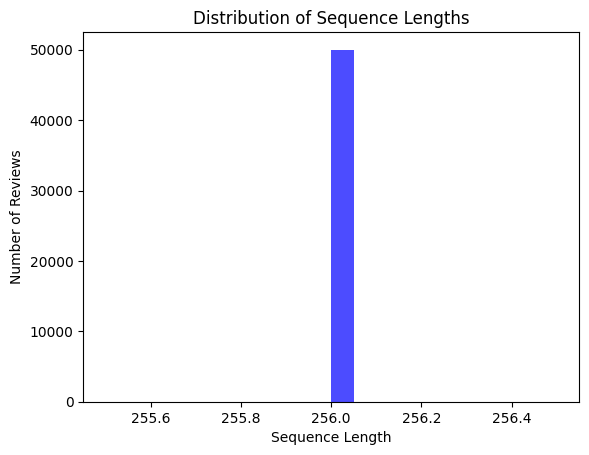

Percentage of reviews exceeding max_length (256 tokens): 0.00%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the lengths of tokenized input sequences (number of tokens per review)
token_lengths = tokenized_dataset['input_ids'].apply(len)

# 1. Average sequence length
average_length = np.mean(token_lengths)
print(f"Average sequence length: {average_length:.2f}")

# 2. Minimum and maximum sequence lengths
min_length = np.min(token_lengths)
max_length = np.max(token_lengths)
print(f"Minimum sequence length: {min_length}")
print(f"Maximum sequence length: {max_length}")

# 3. Histogram of sequence lengths
plt.hist(token_lengths, bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Number of Reviews")
plt.show()

# 4. Percentage of reviews exceeding the max length (256 in this case)
max_length_threshold = 256
exceeding_max_length = np.sum(token_lengths > max_length_threshold)
percentage_exceeding = (exceeding_max_length / len(token_lengths)) * 100
print(f"Percentage of reviews exceeding max_length ({max_length_threshold} tokens): {percentage_exceeding:.2f}%")

## What is an Attention Mask?

Transformer models like BERT process input sequences in batches. To handle sequences of different lengths within a batch, shorter sequences are padded with special tokens to make them all the same length.  

The attention mask is a crucial component that helps the model distinguish between actual words and padding tokens. It's a binary mask (consisting of 0s and 1s) that tells the model which tokens to "pay attention to" and which ones to ignore.

**Here's how it works:**

* **1:** Indicates an actual word token that should be considered.
* **0:** Indicates a padding token that should be ignored.

This ensures that the model focuses on the meaningful content of the input and doesn't get confused by the padding tokens.

In [ ]:
sample_text = df['review'].iloc[1]  # Taking the first review from the dataset as an example
tokenized_sample = tokenizer(sample_text, padding='max_length', truncation=True, max_length=256)

print("Attention Mask Example:")
print(tokenized_sample['attention_mask'])  # Display the attention mask

Attention Mask Example:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Prepare Data for Training

Now that the dataset is tokenized, we need to split it into training and validation sets. This allows us to train the model on one portion of the data and evaluate its performance on a separate, unseen portion.

This cell performs the following steps:

1. **Import `train_test_split`:** Imports the function used to split the data.
2. **Select relevant columns:** Selects the `input_ids`, `attention_mask`, and `label` columns, which are needed for training.
3. **Split the data:** Splits the data into training and validation sets using the `train_test_split` function. The `test_size` parameter determines the proportion of data used for validation.
4. **Display set sizes:** Prints the number of samples in the training and validation sets.

In [ ]:
from sklearn.model_selection import train_test_split

# Select the relevant columns for training and validation
input_columns = ['input_ids', 'attention_mask', 'label']

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(tokenized_dataset[input_columns], test_size=test_size, random_state=1)

# Display the number of samples in each set
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 40000
Validation set size: 10000


## Create Hugging Face Datasets

The `transformers` library provides a convenient way to train models using the `Trainer` class. This class works seamlessly with Hugging Face Datasets. So, in this cell, we convert our training and validation DataFrames into Hugging Face Dataset objects.

This makes it easier to manage the data during training and leverage the features of the `Trainer` API.

In [ ]:
from datasets import Dataset

# Convert the training and validation DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

print(train_dataset[0])

{'input_ids': [101, 2023, 2143, 2038, 2042, 4102, 2000, 1996, 26316, 2329, 4038, 1037, 3869, 2170, 20848, 2348, 1045, 2064, 2102, 2156, 2339, 1996, 2069, 4434, 1045, 2064, 2424, 2003, 1996, 18446, 18750, 2028, 4388, 18373, 1999, 16752, 2198, 18856, 10285, 2063, 1998, 2745, 28619, 2078, 1999, 20848, 4728, 1996, 2048, 2024, 4297, 25377, 25236, 18373, 1998, 12289, 9110, 18053, 2024, 2048, 20067, 2015, 2040, 2215, 2000, 2131, 2041, 1997, 1996, 2449, 2077, 2027, 2203, 2039, 2757, 2061, 2027, 5630, 2000, 10973, 2125, 2037, 5795, 1998, 2191, 2005, 5673, 2043, 1996, 2131, 9497, 3632, 3308, 1996, 2048, 2024, 3140, 2000, 2202, 9277, 1999, 1037, 10664, 2004, 16752, 2054, 2012, 2034, 10659, 2000, 2022, 1037, 11421, 2574, 4150, 1037, 21425, 2779, 3185, 2007, 1996, 5156, 5510, 3238, 3348, 13198, 1998, 20857, 17211, 2320, 2153, 2045, 2024, 1996, 8138, 2152, 7516, 2021, 4445, 3459, 4496, 3626, 6133, 2000, 18708, 8931, 2019, 3535, 2012, 1037, 20848, 2828, 23624, 2278, 3926, 11896, 2205, 2247, 2007, 199

## Load the Pre-trained BERT Model

Now it's time to load the pre-trained BERT model that we'll fine-tune for sentiment analysis.

This cell uses the `BertForSequenceClassification` class from the `transformers` library to load a pre-trained BERT model. We use the `bert-base-uncased` variant, which is a smaller version of BERT that is case-insensitive.

The `num_labels=2` argument specifies that we have two output labels (positive and negative).

In [ ]:
from transformers import BertForSequenceClassification

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Configure Training Parameters

This cell sets up the training parameters using the `TrainingArguments` class from the `transformers` library. These arguments control various aspects of the training process, such as:

* **`output_dir`:**  The directory where the trained model and checkpoints will be saved.
* **`num_train_epochs`:** The number of times the model will be trained on the entire training dataset.
* **`per_device_train_batch_size`:** The batch size for training.
* **`per_device_eval_batch_size`:** The batch size for evaluation.
* **`warmup_steps`:** The number of warmup steps for the learning rate scheduler.

* **`weight_decay`:**  The strength of weight decay (a regularization technique).
* **`logging_dir`:** The directory for storing training logs.
* **`logging_steps`:** How often to log training information (in number of steps).
* **`evaluation_strategy`:**  When to evaluate the model during training ("epoch" means at the end of each iteration).

You can adjust these parameters to experiment with different training settings and potentially improve the model's performance.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',           # Output directory
    num_train_epochs=num_train_epochs,               # Number of training epochs
    per_device_train_batch_size=train_batch_size,   # Batch size for training
    per_device_eval_batch_size=eval_batch_size,    # Batch size for evaluation
    warmup_steps=warmup_steps,                 # Number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                # Strength of weight decay
    logging_dir='./logs',             # Directory for storing logs
    logging_steps=logging_steps,                 # Log every 10 steps
    evaluation_strategy="epoch"       # Evaluate at the end of every epoch
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Fine-tuning with Overfitting Prevention

This cell sets up the training parameters with a focus on preventing overfitting. Overfitting occurs when the model learns the training data too well and performs poorly on unseen data.

Here's how this code addresses overfitting:

* **`num_train_epochs`:** Reduces the number of training epochs to prevent the model from memorizing the training data.
* **`weight_decay`:** Applies weight decay, a regularization technique that penalizes large weights and helps prevent overfitting.
* **`learning_rate`:** Uses a smaller learning rate to make more gradual updates to the model's weights, leading to more stable learning.
* **`evaluation_strategy="steps"`:** Evaluates the model more frequently (every 500 steps) to monitor its performance and detect overfitting early on.
* **`eval_steps=500`:**  Sets the evaluation frequency to 500 steps.
* **`save_steps=500`:** Saves checkpoints every 500 steps, allowing you to revert to earlier versions of the model if overfitting occurs.
* **`load_best_model_at_end=True`:** Ensures that the best performing model (based on evaluation metrics) is loaded at the end of training.

In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=num_train_epochs,               # Reduce the number of epochs
    per_device_train_batch_size=train_batch_size,   # Set batch size
    per_device_eval_batch_size=eval_batch_size,    # Set evaluation batch size
    warmup_steps=warmup_steps,                 # Warmup steps
    weight_decay=weight_decay,                 # Increase weight decay to reduce overfitting
    learning_rate=learning_rate,               # Use a smaller learning rate
    logging_dir='./logs',             # Directory for storing logs
    logging_steps=logging_steps,                 # Log every 10 steps
    evaluation_strategy="steps",      # Evaluate every few steps
    eval_steps=eval_steps,                   # Evaluate every 500 steps
    save_steps=save_steps,                   # Save checkpoint every 500 steps
    load_best_model_at_end=True       # Load the best model at the end of training
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Create the Trainer

This cell creates a `Trainer` object, which is a core component of the `transformers` library for training and evaluating models. The `Trainer` simplifies the training process by handling many of the underlying details.

Here's what this code does:

* **Instantiate `Trainer`:** Creates an instance of the `Trainer` class.
* **Provide model and arguments:** Passes the loaded BERT model (`model`) and the training arguments (`training_args`) to the `Trainer`.
* **Specify datasets:** Provides the training dataset (`train_dataset`) and validation dataset (`val_dataset`) to the `Trainer`.

The `Trainer` object now encapsulates all the necessary information for fine-tuning the BERT model on the IMDB dataset.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,

)

## Create the Trainer with Early Stopping

This cell creates a `Trainer` object, similar to the previous cell, but with the addition of an early stopping callback. Early stopping is a technique to prevent overfitting by monitoring the model's performance on a validation set during training.


Here's what this code does:

* **Import `EarlyStoppingCallback`:** Imports the callback class for early stopping.
* **Instantiate `Trainer`:** Creates an instance of the `Trainer` class, just like before.
* **Add early stopping callback:** Adds the `EarlyStoppingCallback` to the `Trainer`. The `early_stopping_patience` parameter determines how many evaluations to wait for improvement before stopping the training.

**How Early Stopping Works**

Early stopping helps avoid overfitting by monitoring the validation loss during training. If the model's performance on the validation set doesn't improve after a certain number of evaluations (specified by `early_stopping_patience`), the training stops early, preventing the model from learning the training data too well and losing its ability to generalize to new data.


### Note on Using Weights & Biases (wandb) for Logging

The default setup in this notebook has `wandb` (Weights & Biases) logging **disabled**. This is done to simplify the setup for users who do not require experiment tracking or prefer not to use external services. However, `wandb` provides a powerful interface for logging metrics, comparing experiment runs, and visualizing performance.

---

### Disabling wandb by Default
By default, `wandb` logging is turned off by setting `report_to="none"` in the `TrainingArguments`. Here's the code block for training without `wandb`:


In [ ]:
# Early stopping helps avoid overfitting by monitoring the validation loss during training.
# If the model doesn't improve after 'early_stopping_patience' number of evaluations, the training stops early.

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,EarlyStoppingCallback
trainer = Trainer(
    model=model,                         # The pre-trained BERT model
    args=training_args,                  # Training arguments defined earlier
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],  # Add early stopping callback
    report_to="none"  # Disables wandb
)



### Optional: Enable Weights & Biases (wandb) for Experiment Tracking

This code block shows how to enable **Weights & Biases (wandb)** for logging and monitoring your model's training progress. Wandb provides a web interface that allows you to visualize metrics, such as loss and accuracy, in real time.

To use wandb, you will need to create an account and generate an API token. If you choose to use wandb, make sure to uncomment the lines below and set up your wandb project.

- If you prefer not to use wandb, you can simply leave the lines commented out, or you can configure the `Trainer` to report to "none" by setting `report_to="none"` in the `TrainingArguments`.

### Steps to Obtain Your wandb API Token

1. **Visit the wandb Website**:
   - Go to the [Weights & Biases website](https://wandb.ai/site).

2. **Create an Account**:
   - If you don’t have an account yet, click on **"Sign Up"** and fill in the required details.
   - If you already have an account, simply **log in**.

3. **Access Your API Key**:
   - Click on your **profile icon** in the top-right corner of the page.
   - Select **"Settings"** from the dropdown menu.
   - Scroll down to find the **"API Keys"** section.

4. **Copy Your API Key**:
   - Your API key will be displayed here.
   - Click **"Copy"** to copy the API key to your clipboard.

5. **Use the API Key in Your Code**:
   - In your Colab or Jupyter Notebook, use the following code to log in:
     ```python
     import wandb
     wandb.login(key="your_api_key_here")
     ```
   - Replace `"your_api_key_here"` with the API key you copied.

In [ ]:
# from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,EarlyStoppingCallback
# trainer = Trainer(
#     model=model,                         # The pre-trained BERT model
#     args=training_args,                  # Training arguments defined earlier
#     train_dataset=train_dataset,         # Training dataset
#     eval_dataset=val_dataset,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],  # Add early stopping callback
#     report_to="wandb"  # Enable wandb
# )

## Train the Model

This cell starts the fine-tuning process. The `trainer.train()` method initiates the training loop, where the model learns to classify movie reviews as positive or negative.

**Training Time**

The training process might take a while to complete, depending on factors like the dataset size, the number of training epochs, and the available hardware. With the default parameter values, it is expected to take a couple of hours to complete on Colab's free-tier GPU.

**Training Output**

During training, you'll see output that shows the progress, including:

* **Step:** The current training step (iteration).
* **Training Loss:** A measure of how well the model is fitting the training data.
* **Validation Loss:** A measure of how well the model is generalizing to unseen data (the validation set).

The goal is to minimize both the training loss and the validation loss.

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
500,0.348600,0.302999
1000,0.305400,0.272669
1500,0.167700,0.241346
2000,0.198400,0.221074
2500,0.137200,0.201637
3000,0.198400,0.279495
3500,0.102300,0.253804


TrainOutput(global_step=3500, training_loss=0.2482180519104004, metrics={'train_runtime': 3489.4987, 'train_samples_per_second': 34.389, 'train_steps_per_second': 2.149, 'total_flos': 7367109550080000.0, 'train_loss': 0.2482180519104004, 'epoch': 1.4})

## Evaluate the Model

After the fine-tuning process is complete, it's essential to evaluate the model's performance on the validation set. This gives you an estimate of how well the model will generalize to new, unseen data.

This cell uses the `trainer.evaluate()` method to evaluate the model on the validation set. It returns a dictionary of evaluation metrics, such as accuracy, precision, recall, and F1-score.

In [ ]:
eval_results = trainer.evaluate()

## Display Evaluation Results

This cell prints the evaluation results obtained in the previous step. It specifically focuses on the validation accuracy, which is a key metric for assessing the model's performance on unseen data.

The `eval_results` dictionary contains various metrics, and this code extracts and prints the accuracy value.

In [ ]:
print(f"Validation Accuracy: {eval_results}")

Validation Accuracy: {'eval_loss': 0.20163710415363312, 'eval_runtime': 133.1836, 'eval_samples_per_second': 75.084, 'eval_steps_per_second': 4.693, 'epoch': 1.4}


## Fine-tuned Model Performance

This cell dives deeper into evaluating the performance of the fine-tuned BERT model. It calculates additional metrics beyond just accuracy to provide a more comprehensive assessment.

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Generate predictions and true labels
predictions, labels, _ = trainer.predict(val_dataset)

# Convert predictions to a PyTorch tensor and then apply argmax
predicted_classes = torch.tensor(predictions).argmax(dim=1)

# Convert labels to tensor if they are not already
labels = torch.tensor(labels)

# Calculate accuracy
accuracy = accuracy_score(labels, predicted_classes)
print(f"Validation Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_classes, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Validation Accuracy: 0.9259
Precision: 0.9272
Recall: 0.9229
F1-Score: 0.9251


## Base Model Performance Test

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def tokenize_and_prepare_data(df, tokenizer, max_length=256):
    """
    Tokenize the text data and prepare it for BERT
    """
    # Tokenize all reviews
    encoded_data = tokenizer(
        df['review'].tolist(),
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        max_length=max_length,
        truncation=True,
        return_tensors='pt'
    )

    # Convert labels to tensor
    df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
    labels = torch.tensor(df['label'].tolist())

    return encoded_data['input_ids'], encoded_data['attention_mask'], labels

def evaluate_base_bert(val_df, batch_size=16, max_length=256):
    # Load the tokenizer and base model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    base_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    base_model = base_model.to(device)
    base_model.eval()  # Set to evaluation mode

    # Tokenize and prepare the validation data
    print("Tokenizing validation data...")
    val_inputs, val_masks, val_labels = tokenize_and_prepare_data(val_df, tokenizer, max_length)

    # Create DataLoader for validation set
    val_data = TensorDataset(val_inputs, val_masks, val_labels)
    val_dataloader = DataLoader(val_data, batch_size=batch_size)

    # Lists to store predictions and true labels
    all_predictions = []
    all_labels = []

    print("Evaluating base model...")
    # Evaluate without gradient computation
    with torch.no_grad():
        for batch in val_dataloader:
            # Unpack the batch and move to GPU
            batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

            # Get model outputs
            outputs = base_model(batch_inputs, attention_mask=batch_masks)
            logits = outputs.logits

            # Convert logits to predictions
            predictions = torch.argmax(logits, dim=1)

            # Move predictions and labels to CPU for metric calculation
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

    # Print results
    print("\nBase BERT Model Performance (No Fine-tuning):")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# Run the evaluation
print("Starting base BERT model evaluation...")
base_metrics = evaluate_base_bert(df)

Starting base BERT model evaluation...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing validation data...
Evaluating base model...

Base BERT Model Performance (No Fine-tuning):
Validation Accuracy: 0.5000
Precision: 0.5000
Recall: 0.9999
F1-Score: 0.6666
